In [192]:
from rdflib.term import Literal
from rdflib import Graph
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate
from scipy import stats
from rdflib import Graph, Namespace, RDF, RDFS, XSD, Literal
from sdv.single_table import CTGANSynthesizer

In [25]:

ttl_file_path = 'C:/Users/Jesse/Thesis/OfficeGraph-main/airwits_devices_part1/airwits_devices_part1/C2E8A0.ttl'

# Create an RDF graph
g = Graph()

# Parse the TTL file and load its contents into the graph
g.parse(ttl_file_path, format='ttl')

<Graph identifier=N46fe089a018642aeb1bd1afc0b66cdea (<class 'rdflib.graph.Graph'>)>

In [26]:
count = 0
temp_values = []
co2_values = []
humidity_values = []
time_obj = []
# Iterate over each triple in the graph
for subj, pred, obj in g:
    # Print the triple
    # Increment the counter
    if str(pred) == "https://saref.etsi.org/core/hasValue":
        if "temp" in str(subj):
            temp_values.append(float(obj))
        if "co2" in str(subj):
            co2_values.append(float(obj))
        if "humidity" in str(subj):
            humidity_values.append(float(obj))
        if count < 5:
            print(subj,"   ",pred,"   ",obj)
            count += 1
    if str(pred) == "https://saref.etsi.org/core/hasTimestamp": 
        time_obj.append(datetime.strptime(obj, "%Y-%m-%dT%H:%M:%S"))
print(len(temp_values))


https://interconnectproject.eu/example/measurement_R5_203__temp__10539     https://saref.etsi.org/core/hasValue     21.5
https://interconnectproject.eu/example/measurement_R5_203__temp__14317     https://saref.etsi.org/core/hasValue     17.5
https://interconnectproject.eu/example/measurement_R5_203__co2__5991     https://saref.etsi.org/core/hasValue     470.0
https://interconnectproject.eu/example/measurement_R5_203__humidity__3108     https://saref.etsi.org/core/hasValue     30.0
https://interconnectproject.eu/example/measurement_R5_203__co2__15514     https://saref.etsi.org/core/hasValue     483.0
15954


In [27]:
triple_labels = {}
measurement_number = 0
counter = 0
for triples in g:
        last_underscore_index = triples[0].rfind('_')
        label = triples[0][last_underscore_index + 1:]
        if label.isdigit():
                integer_label = int(label)
        
                if integer_label in triple_labels:
                # Append the triple to the list corresponding to the label
                        if triples[1] in "https://saref.etsi.org/core/hasTimestamp":
                                triple_labels[integer_label][0] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "co2" in triples[0]:
                                triple_labels[integer_label][1] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "temp" in triples[0]:
                                triple_labels[integer_label][2] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "humidity" in triples[0]:
                                triple_labels[integer_label][3] = triples[2].toPython()
                else:
                # Create a new list for the label and add the triple
                        triple_labels[integer_label] = [0,1,2,3]
                        if triples[1] in "https://saref.etsi.org/core/hasTimestamp":
                                triple_labels[integer_label][0] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "co2" in triples[0]:
                                triple_labels[integer_label][1] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "temp" in triples[0]:
                                triple_labels[integer_label][2] = triples[2].toPython()
                        elif triples[1] in "https://saref.etsi.org/core/hasValue" and "humidity" in triples[0]:
                                triple_labels[integer_label][3] = triples[2].toPython()

In [28]:
counter = 0
for label in sorted(triple_labels.keys()):
    if counter < 20:
        print(triple_labels[label])
        counter += 1

[datetime.datetime(2022, 3, 1, 0, 8), 453.0, 21.6, 26.0]
[datetime.datetime(2022, 3, 1, 0, 37), 464.0, 21.5, 27.0]
[datetime.datetime(2022, 3, 1, 1, 7), 480.0, 21.5, 27.0]
[datetime.datetime(2022, 3, 1, 1, 37), 460.0, 21.4, 27.0]
[datetime.datetime(2022, 3, 1, 2, 7), 491.0, 21.3, 27.0]
[datetime.datetime(2022, 3, 1, 2, 36), 447.0, 21.2, 27.0]
[datetime.datetime(2022, 3, 1, 3, 6), 462.0, 21.1, 27.0]
[datetime.datetime(2022, 3, 1, 3, 36), 475.0, 21.1, 27.0]
[datetime.datetime(2022, 3, 1, 4, 6), 450.0, 21.0, 27.0]
[datetime.datetime(2022, 3, 1, 4, 35), 455.0, 20.9, 27.0]
[datetime.datetime(2022, 3, 1, 5, 5), 473.0, 20.9, 27.0]
[datetime.datetime(2022, 3, 1, 5, 36), 443.0, 21.1, 27.0]
[datetime.datetime(2022, 3, 1, 6, 5), 451.0, 21.3, 27.0]
[datetime.datetime(2022, 3, 1, 6, 35), 477.0, 21.4, 25.0]
[datetime.datetime(2022, 3, 1, 7, 4), 472.0, 21.5, 24.0]
[datetime.datetime(2022, 3, 1, 7, 34), 466.0, 21.5, 24.0]
[datetime.datetime(2022, 3, 1, 8, 4), 466.0, 21.4, 24.0]
[datetime.datetime(2022

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_data = pd.DataFrame.from_dict(triple_labels)
df_data = df_data.T
df_data.columns = ["time", "co2_values", "temp_values", "humidity_values"]
df_data.sort_values(by=["time"]).head(n=50)

,time,co2_values,temp_values,humidity_values
0,2022-03-01 00:08:00,453.0,21.6,26.0
1,2022-03-01 00:37:00,464.0,21.5,27.0
2,2022-03-01 01:07:00,480.0,21.5,27.0
3,2022-03-01 01:37:00,460.0,21.4,27.0
4,2022-03-01 02:07:00,491.0,21.3,27.0
5,2022-03-01 02:36:00,447.0,21.2,27.0
6,2022-03-01 03:06:00,462.0,21.1,27.0
7,2022-03-01 03:36:00,475.0,21.1,27.0
8,2022-03-01 04:06:00,450.0,21.0,27.0
9,2022-03-01 04:35:00,455.0,20.9,27.0


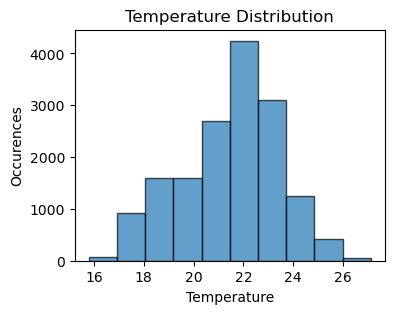

In [30]:
plt.figure(figsize=(4, 3))
plt.hist(df_data["temp_values"], bins=10, edgecolor='black', alpha=0.7)
plt.title("Temperature Distribution")
plt.xlabel("Temperature")
plt.ylabel("Occurences")
plt.show()

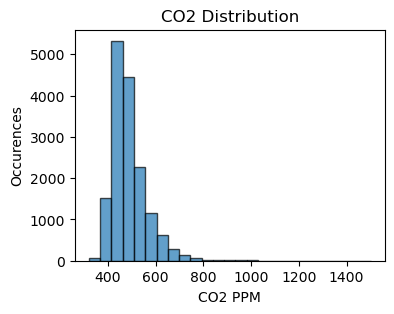

In [31]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_data["co2_values"], bins=25, edgecolor='black', alpha=0.7)
plt.title("CO2 Distribution")
plt.xlabel("CO2 PPM")
plt.ylabel("Occurences")
plt.show()

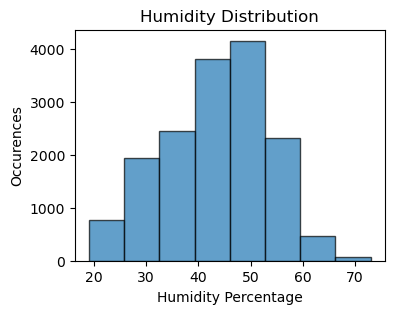

In [32]:
plt.figure(figsize=(4, 3)) 
plt.hist(df_data["humidity_values"], bins=8, edgecolor='black', alpha=0.7)
plt.title("Humidity Distribution")
plt.xlabel("Humidity Percentage")
plt.ylabel("Occurences")
plt.show()

In [33]:
df_data = df_data.sort_values(by="time")
df_data["co2_values"] = df_data["co2_values"].astype(float)
df_data["temp_values"] = df_data["temp_values"].astype(float)
df_data["humidity_values"] = df_data["humidity_values"].astype(float)
df_data["time"] = df_data["time"].apply(lambda x: datetime.timestamp(x))


In [34]:
df_data.head()

,time,co2_values,temp_values,humidity_values
0,1.646090e+09,453.0,21.6,26.0
1,1.646091e+09,464.0,21.5,27.0
2,1.646093e+09,480.0,21.5,27.0
3,1.646095e+09,460.0,21.4,27.0
4,1.646097e+09,491.0,21.3,27.0


In [35]:
scaler = MinMaxScaler()

In [36]:
scaled_data = scaler.fit_transform(df_data)

In [105]:
print(scaled_data)

[[0.00000000e+00 1.12616427e-01 5.13274336e-01 1.29629630e-01]
 [5.97626393e-05 1.21930567e-01 5.04424779e-01 1.48148148e-01]
 [1.21586059e-04 1.35478408e-01 5.04424779e-01 1.48148148e-01]
 ...
 [9.99874292e-01 1.44792549e-01 2.83185841e-01 3.70370370e-01]
 [9.99936116e-01 1.49026249e-01 2.74336283e-01 3.70370370e-01]
 [1.00000000e+00 1.28704488e-01 2.65486726e-01 3.70370370e-01]]


In [38]:
from timegan import timegan

In [39]:
list_data = scaled_data.tolist()

In [106]:
temp_data = []    
  # Cut data by sequence length
for i in range(0, len(list_data) - len(list_data[0])):
    _x = list_data[i:i + len(list_data[0])]
    temp_data.append(_x)
        
  # Mix the datasets (to make it similar to i.i.d)
idx = np.random.permutation(len(temp_data))    
data = []
for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])

In [157]:
parameters = dict()
parameters['module'] = 'gru' 
parameters['hidden_dim'] = 6
parameters['num_layer'] = 3
parameters['iterations'] = 3000
parameters['batch_size'] = 128

In [158]:
generated_data = timegan(np.asarray(data), parameters)   
print('Finish Synthetic Data Generation')

c:\Users\Jesse\Thesis\DataGenCode\utils.py:95: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  rnn_cell = tf.compat.v1.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)


Start Embedding Network Training
step: 0/3000, e_loss: 0.2672
step: 1000/3000, e_loss: 0.1821
step: 2000/3000, e_loss: 0.1333
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/3000, s_loss: 0.2772
step: 1000/3000, s_loss: 0.0889
step: 2000/3000, s_loss: 0.0806
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/3000, d_loss: 2.082, g_loss_u: 0.689, g_loss_s: 0.0798, g_loss_v: 0.3414, e_loss_t0: 0.1192
step: 1000/3000, d_loss: 0.1505, g_loss_u: 3.623, g_loss_s: 0.0781, g_loss_v: 0.2201, e_loss_t0: 0.1114
step: 2000/3000, d_loss: 0.1512, g_loss_u: 3.6082, g_loss_s: 0.0839, g_loss_v: 0.2069, e_loss_t0: 0.1126
Finish Joint Training
Finish Synthetic Data Generation


In [148]:
print(type(generated_data))

<class 'numpy.ndarray'>


In [159]:
transformed_synt_df = generated_data.reshape(-1, generated_data.shape[-1])
synt_array = scaler.inverse_transform(transformed_synt_df)

In [160]:
synt_df = pd.DataFrame(synt_array, columns=["time", "co2_values", "temp_values", "humidity_values"])

In [161]:
synt_df['time'] = synt_df['time'].apply(lambda x: datetime.fromtimestamp(x))
synt_df["time"] = pd.to_datetime(synt_df["time"])
synt_df["time"] = synt_df["time"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
synt_df["co2_values"] = synt_df["co2_values"].apply(lambda x: (round(x, 1)))
synt_df["temp_values"] = synt_df["temp_values"].apply(lambda x: (round(x, 1)))
synt_df["humidity_values"] = synt_df["humidity_values"].apply(lambda x: (round(x, 1)))

In [162]:
sampled_df = synt_df.sample(frac=0.25, random_state=2)

In [188]:
sampled_df["time"] = pd.to_datetime(sampled_df["time"])

In [126]:
with open('synt_timegan_table.txt', 'w') as outputfile:
    outputfile.write(tabulate(synt_df))

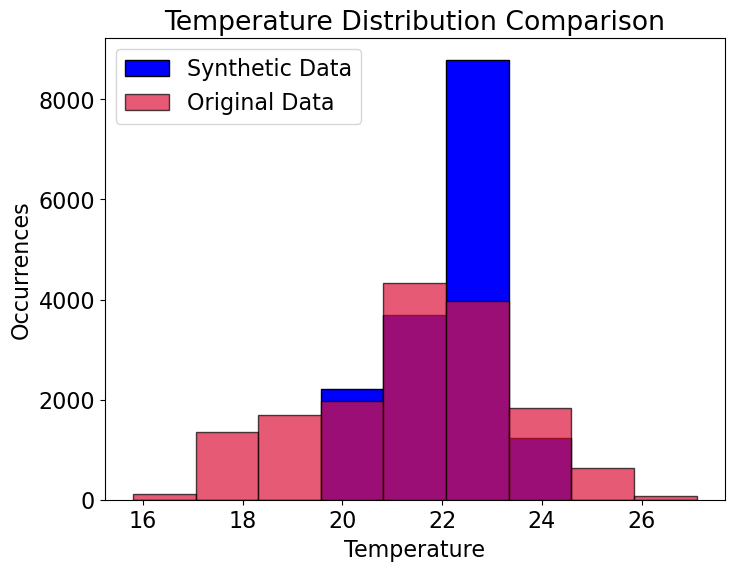

In [232]:
plt.rcParams.update({'font.size': 16})
min_value = min(sampled_df["temp_values"].min(), df_data["temp_values"].min())
max_value = max(sampled_df["temp_values"].max(), df_data["temp_values"].max())
bins = np.linspace(min_value, max_value, 10)
plt.figure(figsize=(8, 6)) 
plt.hist(sampled_df["temp_values"], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(df_data["temp_values"], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Temperature Distribution Comparison")
plt.xlabel("Temperature")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

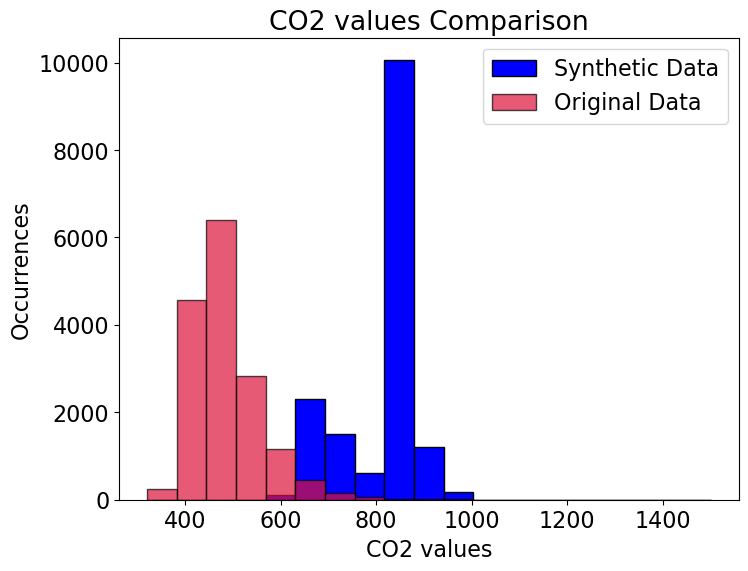

In [235]:
min_value = min(sampled_df["co2_values"].min(), df_data["co2_values"].min())
max_value = max(sampled_df["co2_values"].max(), df_data["co2_values"].max())
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(8, 6)) 
plt.hist(sampled_df["co2_values"], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(df_data["co2_values"], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("CO2 values Comparison")
plt.xlabel("CO2 values")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

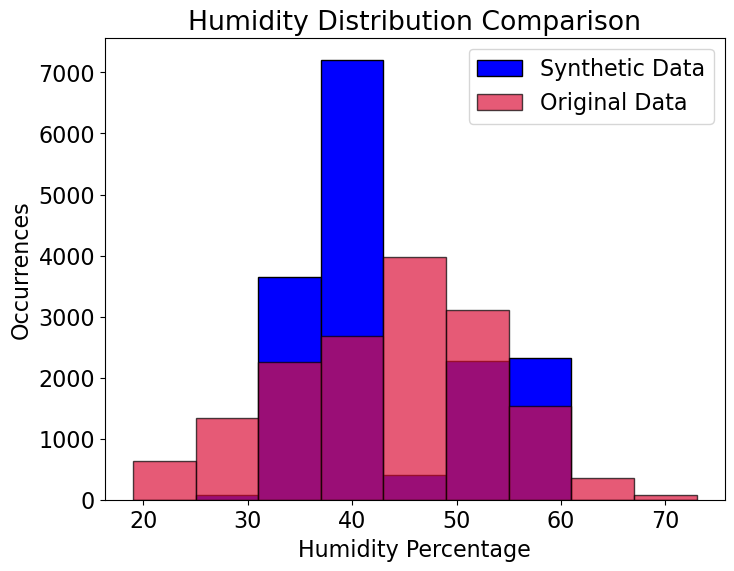

In [234]:
min_value = min(sampled_df["humidity_values"].min(), df_data["humidity_values"].min())
max_value = max(sampled_df["humidity_values"].max(), df_data["humidity_values"].max())
bins = np.linspace(min_value, max_value, 10)
plt.figure(figsize=(8, 6)) 
plt.hist(sampled_df["humidity_values"], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(df_data["humidity_values"], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Humidity Distribution Comparison")
plt.xlabel("Humidity Percentage")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

In [267]:
sampled_df.sort_values(by="time")[9000:9050]

,time,co2_values,temp_values,humidity_values
545,2022-08-01 02:51:26,823.8,22.5,37.2
35678,2022-08-01 02:56:41,956.5,24.0,37.2
58859,2022-08-01 03:00:17,839.8,22.2,31.1
23097,2022-08-01 03:11:16,822.9,22.5,37.5
42515,2022-08-01 03:17:20,861.4,22.6,35.6
11578,2022-08-01 03:18:27,954.9,23.9,37.0
27514,2022-08-01 03:25:12,829.5,22.5,33.5
48395,2022-08-01 03:29:32,831.8,22.5,32.3
27927,2022-08-01 03:36:22,832.2,22.5,32.3
21258,2022-08-01 03:51:22,829.6,22.5,33.5


In [170]:
def euclidean_distance(feature):
    euclidian_distances = []
    previous_data = False
    for row in feature:
        current_data = row
        if previous_data:
            euclidian_distances.append(np.sqrt((current_data - old_data) ** 2))
        previous_data = True
        old_data = current_data
    return euclidian_distances

In [237]:
columns_to_test = [col for col in df_data.columns if col != "time"]
real_values = []
synt_values = []
all_real_distances = []
all_synt_distances = []
for i in columns_to_test:
    real_distances = euclidean_distance(df_data.sort_values(by="time")[i])
    synt_distances = euclidean_distance(sampled_df.sort_values(by="time")[i])
    all_real_distances += [real_distances]
    all_synt_distances += [synt_distances]
    real_values += [[np.mean(real_distances), np.std(real_distances, ddof=1)]]
    synt_values += [[np.mean(synt_distances), np.std(synt_distances, ddof=1)]]


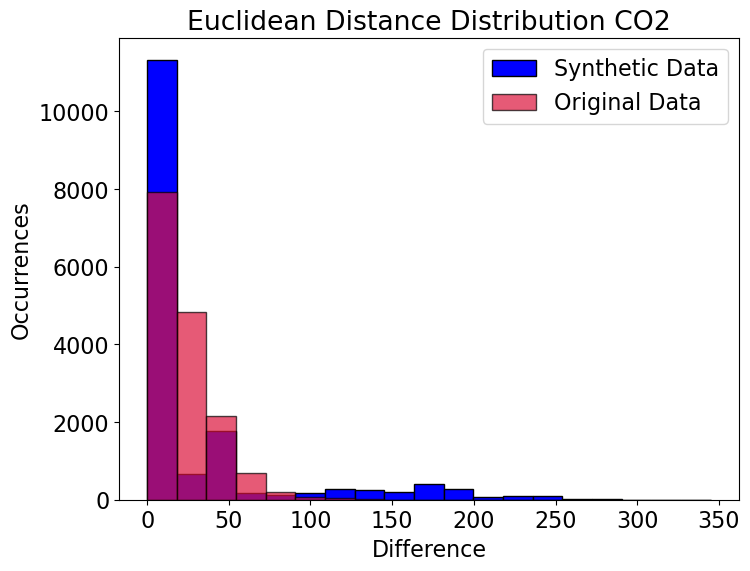

In [254]:
min_value = min(min(all_real_distances[0]), min(all_synt_distances[0]))
max_value = max(max(all_real_distances[0]), max(all_synt_distances[0]))
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(8, 6)) 
plt.hist(all_synt_distances[0], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(all_real_distances[0], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Euclidean Distance Distribution CO2")
plt.xlabel("Difference")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

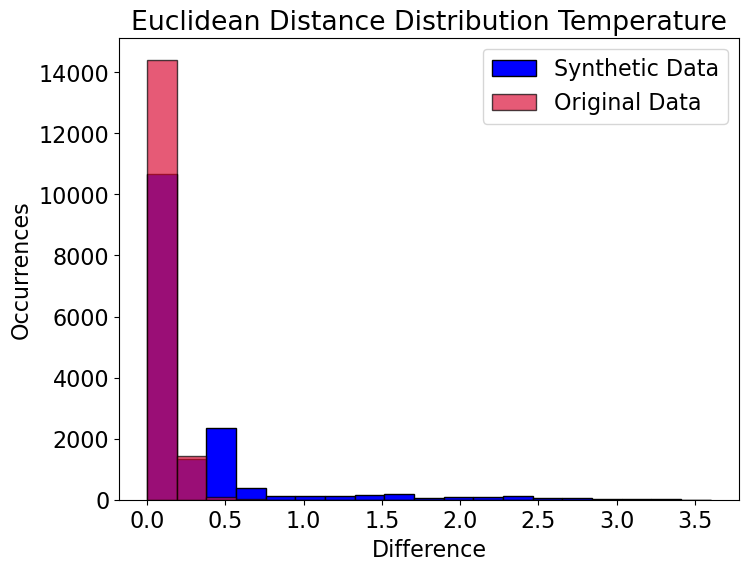

In [255]:
min_value = min(min(all_real_distances[1]), min(all_synt_distances[1]))
max_value = max(max(all_real_distances[1]), max(all_synt_distances[1]))
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(8, 6)) 
plt.hist(all_synt_distances[1], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(all_real_distances[1], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Euclidean Distance Distribution Temperature")
plt.xlabel("Difference")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

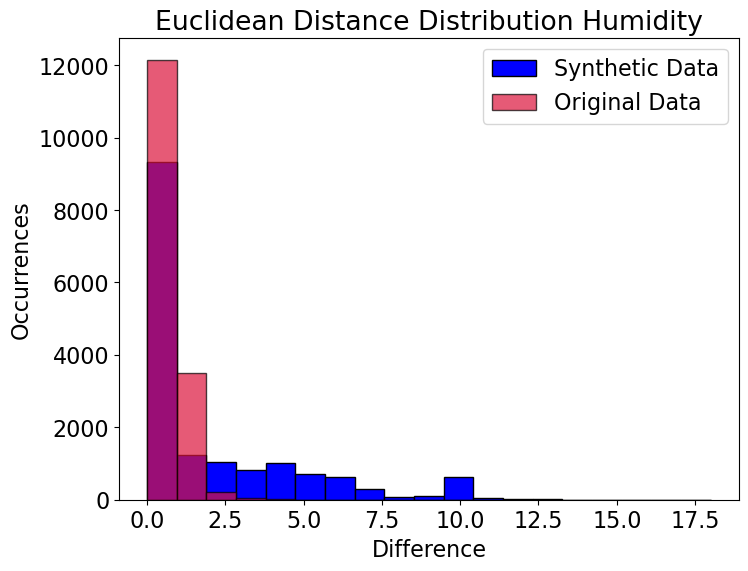

In [256]:
min_value = min(min(all_real_distances[2]), min(all_synt_distances[2]))
max_value = max(max(all_real_distances[2]), max(all_synt_distances[2]))
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(8, 6)) 
plt.hist(all_synt_distances[2], bins=bins, edgecolor='black', alpha=1, label='Synthetic Data', color='blue')
plt.hist(all_real_distances[2], bins=bins, edgecolor='black', alpha=0.7, label='Original Data', color='crimson')
plt.title("Euclidean Distance Distribution Humidity")
plt.xlabel("Difference")
plt.ylabel("Occurrences")
plt.legend()
plt.show()

In [172]:
print(real_values)
print(synt_values)

[[23.19494765874757, 20.022194481735117], [0.06575565724315176, 0.08107010427659582], [0.2649658371466182, 0.5505416662503038]]
[[28.601279077058123, 54.26592436924885], [0.2528935983447238, 0.5057568610859519], [1.9021882249670825, 2.773352786862064]]


In [173]:
t_test_results = []


for i in range(len(real_values)):
    t_test, p_value = stats.ttest_ind_from_stats(mean1=real_values[i][0], std1=real_values[i][1], nobs1=len(df_data["time"]),
                                                 mean2=synt_values[i][0], std2=synt_values[i][1], nobs2=len(sampled_df["time"]))
    t_test_results.append((i, t_test, p_value))

for column, t_stat, p_value in t_test_results:
    print(f"Feature {column}: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")

Feature 0: t-statistic = -11.81, p-value = 0.000
Feature 1: t-statistic = -46.15, p-value = 0.000
Feature 2: t-statistic = -73.14, p-value = 0.000


In [230]:
t_test_results2 = []
for i in columns_to_test:
    t_test, p_value = stats.ttest_ind_from_stats(mean1=np.mean(df_data[i]), std1=np.std(df_data[i]), nobs1=len(df_data["time"]),
                                                 mean2=np.mean(sampled_df[i]), std2=np.std(sampled_df[i]), nobs2=len(sampled_df["time"]))
    t_test_results2.append((i, t_test, p_value))
    
for column, t_stat, p_value in t_test_results2:
    print(f"Feature {column}: t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")

Feature co2_values: t-statistic = -381.23, p-value = 0.000
Feature temp_values: t-statistic = -34.08, p-value = 0.000
Feature humidity_values: t-statistic = 4.57, p-value = 0.000


In [181]:
synt_graph = Graph()

ic = Namespace("https://interconnectproject.eu/example/")
saref = Namespace("https://saref.etsi.org/core/")
s4ener = Namespace("https://saref.etsi.org/saref4ener/")
s4bldg = Namespace("https://saref.etsi.org/saref4bldg/")
om = Namespace("http://www.wurvoc.org/vocabularies/om-1.8/")

synt_graph.bind("ic", "https://interconnectproject.eu/example/")
synt_graph.bind("saref", "https://saref.etsi.org/core/")
synt_graph.bind("s4ener", "https://saref.etsi.org/saref4ener/") #removed version number
synt_graph.bind("s4bldg", "https://saref.etsi.org/saref4bldg/") #removed version number
synt_graph.bind("om", "http://www.wurvoc.org/vocabularies/om-1.8/")

In [182]:
def MakeCO2Uri(row_number):
    return ic["measurement_R5_synt_co2_"+str(row_number)]
def MakeTempUri(row_number):
    return ic["measurement_R5_synt_temp_"+str(row_number)]
def MakeHumidityUri(row_number):
    return ic["measurement_R5_synt_humidity_"+str(row_number)]

In [189]:
synt_graph.add((ic.synt_R5, RDF.type, s4ener.Device))
synt_graph.add((ic.synt_R5, ic.hasDeviceType, Literal("Airwits", datatype=XSD.string)))
synt_graph.add((ic.synt_R5, ic.hasModel, Literal("R5", datatype=XSD.string)))
synt_graph.add((s4ener.Device, RDFS.subClassOf, saref.Device))
row_counter = 0

for index, row in sampled_df.sort_values(by="time").iterrows():
    row_counter += 1
    co2_uri = MakeCO2Uri(row_counter)
    synt_graph.add((ic.synt_R5, saref.makesMeasurement, co2_uri))
    synt_graph.add((co2_uri, RDF.type, saref.Measurement))
    synt_graph.add((co2_uri, saref.hasTimestamp, Literal(row.iloc[0], datatype=XSD.dateTime)))
    synt_graph.add((co2_uri, saref.hasValue, Literal(row.iloc[1], datatype=XSD.float)))
    synt_graph.add((co2_uri, saref.isMeasuredIn, om.partsPerMillion))
    synt_graph.add((co2_uri, saref.relatesToProperty, ic.property_R5_synt_co2_))

    temp_uri = MakeTempUri(row_counter)
    synt_graph.add((ic.synt_R5, saref.makesMeasurement, temp_uri))
    synt_graph.add((temp_uri, RDF.type, saref.Measurement))
    synt_graph.add((temp_uri, saref.hasTimestamp, Literal(row.iloc[0], datatype=XSD.dateTime)))
    synt_graph.add((temp_uri, saref.hasValue, Literal(row.iloc[2], datatype=XSD.float)))
    synt_graph.add((temp_uri, saref.isMeasuredIn, om.degreeCelsius))
    synt_graph.add((temp_uri, saref.relatesToProperty, ic.property_R5_synt_temp_))

    humidity_uri = MakeHumidityUri(row_counter)
    synt_graph.add((ic.synt_R5, saref.makesMeasurement, humidity_uri))
    synt_graph.add((humidity_uri, RDF.type, saref.Measurement))
    synt_graph.add((humidity_uri, saref.hasTimestamp, Literal(row.iloc[0], datatype=XSD.dateTime)))
    synt_graph.add((humidity_uri, saref.hasValue, Literal(row.iloc[3], datatype=XSD.float)))
    synt_graph.add((humidity_uri, saref.isMeasuredIn, om.percent))
    synt_graph.add((humidity_uri, saref.relatesToProperty, ic.property_R5_synt_humidity_))

synt_graph.add((ic.property_R5_synt_co2_, RDF.type, ic.CO2Level))
synt_graph.add((ic.property_R5_synt_temp_, RDF.type, saref.Temperature))
synt_graph.add((ic.property_R5_synt_humidity_, RDF.type, saref.Humidity))

<Graph identifier=N56074dafd6ce47f0b846f67d83db9256 (<class 'rdflib.graph.Graph'>)>

In [190]:
synt_graph.serialize("TimeGAN_graph.ttl", format="ttl")

<Graph identifier=N56074dafd6ce47f0b846f67d83db9256 (<class 'rdflib.graph.Graph'>)>

In [193]:
model = CTGANSynthesizer.load("lr2e-3epoch1000.pkl")
synt_data = model.sample(15954)
synt_data["time"] = pd.to_datetime(synt_data["time"])

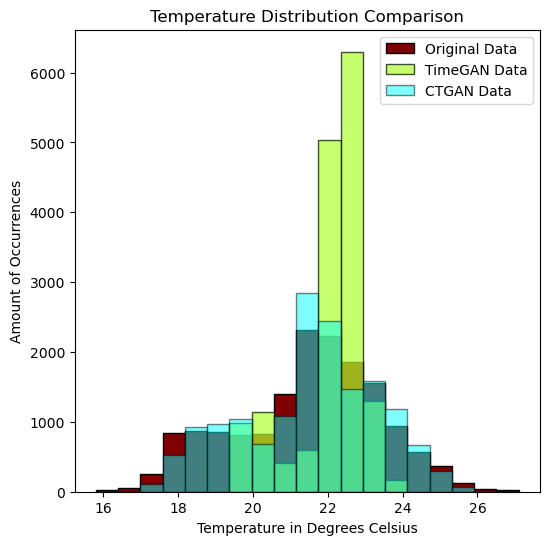

In [221]:
min_value = min(sampled_df["temp_values"].min(), df_data["temp_values"].min(), synt_data["temp_values"].min())
max_value = max(sampled_df["temp_values"].max(), df_data["temp_values"].max(), synt_data["temp_values"].max())
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(6, 6)) 
plt.hist(df_data["temp_values"], bins=bins, edgecolor='black', alpha=1, label='Original Data', color='maroon')
plt.hist(sampled_df["temp_values"], bins=bins, edgecolor='black', alpha=0.7, label='TimeGAN Data', color='greenyellow')
plt.hist(synt_data["temp_values"], bins=bins, edgecolor='black', alpha=0.5, label='CTGAN Data', color='aqua')
plt.title("Temperature Distribution Comparison")
plt.xlabel("Temperature in Degrees Celsius")
plt.ylabel("Amount of Occurrences")
plt.legend()
plt.show()

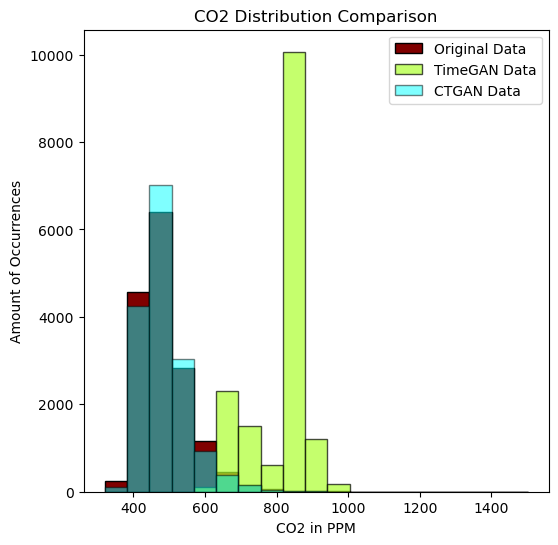

In [222]:
min_value = min(sampled_df["co2_values"].min(), df_data["co2_values"].min(), synt_data["co2_values"].min())
max_value = max(sampled_df["co2_values"].max(), df_data["co2_values"].max(), synt_data["co2_values"].max())
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(6, 6)) 
plt.hist(df_data["co2_values"], bins=bins, edgecolor='black', alpha=1, label='Original Data', color='maroon')
plt.hist(sampled_df["co2_values"], bins=bins, edgecolor='black', alpha=0.7, label='TimeGAN Data', color='greenyellow')
plt.hist(synt_data["co2_values"], bins=bins, edgecolor='black', alpha=0.5, label='CTGAN Data', color='aqua')
plt.title("CO2 Distribution Comparison")
plt.xlabel("CO2 in PPM")
plt.ylabel("Amount of Occurrences")
plt.legend()
plt.show()

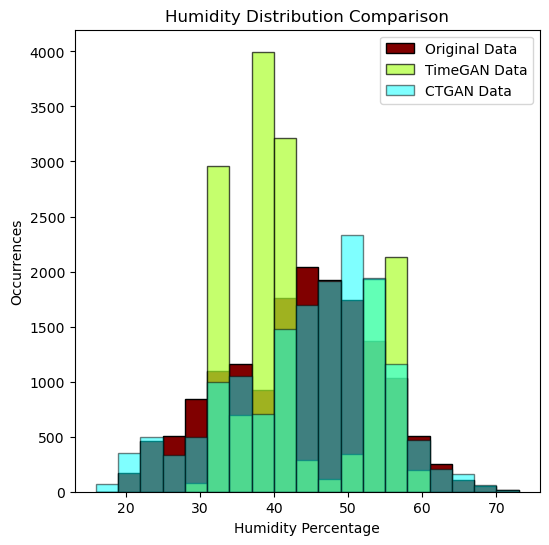

In [223]:
min_value = min(sampled_df["humidity_values"].min(), df_data["humidity_values"].min(), synt_data["humidity_values"].min())
max_value = max(sampled_df["humidity_values"].max(), df_data["humidity_values"].max(), synt_data["humidity_values"].max())
bins = np.linspace(min_value, max_value, 20)
plt.figure(figsize=(6, 6)) 
plt.hist(df_data["humidity_values"], bins=bins, edgecolor='black', alpha=1, label='Original Data', color='maroon')
plt.hist(sampled_df["humidity_values"], bins=bins, edgecolor='black', alpha=0.7, label='TimeGAN Data', color='greenyellow')
plt.hist(synt_data["humidity_values"], bins=bins, edgecolor='black', alpha=0.5, label='CTGAN Data', color='aqua')
plt.title("Humidity Distribution Comparison")
plt.xlabel("Humidity Percentage")
plt.ylabel("Occurrences")
plt.legend()
plt.show()